In [1]:
!pip install --upgrade tfds-nightly
!pip install --upgrade tensorflow tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Succes

In [2]:
import time
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# EMNIST 데이터셋 로드
ds_builder = tfds.builder("emnist/balanced")
ds_builder.download_and_prepare()
ds_info = ds_builder.info
dataset = ds_builder.as_data_source()

# Label Mapping
label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'
]

# 이미지 크기 조정 및 정규화
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # 이미지 크기를 224x224로 조정
    image = tf.image.grayscale_to_rgb(image)    # 그레이스케일 이미지를 RGB로 변환
    image = image / 255.0                       # 정규화
    return image, label

# 데이터 생성 (train, test)
X = []
y = []
for example in dataset['train']:
    X.append(example['image'])
    y.append(example['label'])

X_test = []
y_test = []
for example in dataset['test']:
    X_test.append(example['image'])
    y_test.append(example['label'])

X = np.array(X)
y = np.array(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# dataset 분할 (train:validation = 5:1), test dataset은 emnist dataset에 있는 것으로 사용
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/6, random_state=42)

# Label 변환(integer -> character)
def convert_labels_to_characters(labels, label_mapping):
    return np.array([label_mapping[label] for label in labels])

# y_train = convert_labels_to_characters(y_train, label_mapping)
# y_valid = convert_labels_to_characters(y_valid, label_mapping)
# y_test = convert_labels_to_characters(y_test, label_mapping)

# 데이터셋 구성 및 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess).shuffle(1000).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(preprocess).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess).batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/112800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.1GXO3V_3.1.0/emnist-train.array_record*...:   0…

Generating test examples...:   0%|          | 0/18800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.1GXO3V_3.1.0/emnist-test.array_record*...:   0%…

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.1.0. Subsequent calls will reuse this data.


In [3]:
# Mobilenet V3 모델 정의
def mobilenet_v3_model():
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(label_mapping), activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# 모델 생성
model = mobilenet_v3_model()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       5,537,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 47)                  │           6,063 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,567,567 (21.24 MB)

 Trainable params: 5,567,567 (21.24 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 25
LEARNING_RATE = 0.001

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습

start_time = time.time()
history = model.fit(train_dataset, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=valid_dataset)

training_time = time.time() - start_time

Epoch 1/25
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 142s 47ms/step - accuracy: 0.9934 - loss: 0.0210 - val_accuracy: 0.8311 - val_loss: 1.9819
Epoch 2/25
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 134s 45ms/step - accuracy: 0.9927 - loss: 0.0227 - val_accuracy: 0.8222 - val_loss: 1.8897
Epoch 3/25
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 147s 47ms/step - accuracy: 0.9933 - loss: 0.0219 - val_accuracy: 0.8336 - val_loss: 1.6248
Epoch 4/25
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 137s 46ms/step - accuracy: 0.9947 - loss: 0.0192 - val_accuracy: 0.8311 - val_loss: 1.6021
Epoch 5/25
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 139s 46ms/step - accuracy: 0.9933 - loss: 0.0218 - val_accuracy: 0.8313 - val_loss: 2.0870
Epoch 6/25
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 132s 45ms/step - accuracy: 0.9947 - loss: 0.0178 - val_accuracy: 0.8266 - val_loss: 2.0193
Epoch 7/25
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 149s 47ms/step - accuracy: 0.9944 - loss: 0.0180 - val_accuracy: 0.8290 - val_loss: 2.2397
Epoch 8/25
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 136s 45ms/step - accuracy: 

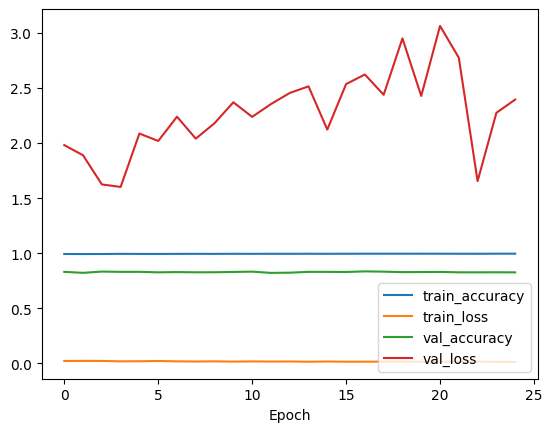

In [14]:
# 학습 결과 시각화
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()


In [22]:
# 테스트 데이터 예측 및 예측 시간(inference time) 측정

start_time = time.time()  # 추론 시작 시간
predictions = model.predict(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

# 테스트 데이터에 대한 예측 결과 처리
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test, axis=0)

# 정확도 계산
correct_predictions = np.sum(predicted_classes == actual_classes)
accuracy = correct_predictions / len(predicted_classes)

# 결과 출력
print(f"Correct Predictions: {correct_predictions}")
print(f"Total Predictions: {len(predicted_classes)}")
print(f"정확도: {accuracy:.2f}")
print(f"훈련시간 : {training_time:.2f} seconds.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

588/588 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step
Correct Predictions: 377
Total Predictions: 18800
정확도: 0.02
훈련시간 : 3535.65 seconds.
평균 추론 시간: 0.0009 seconds.
